In [2]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
# import packages
import pandas as pd
from political_ads.Preprocessor import *
from political_ads.helper import *
from political_ads.keyword_filter import *
import matplotlib.pyplot as plt

In [3]:
#Code to read from our full dataset:
preprocess = Preprocessor()
df = preprocess.file_to_df('/home/gustavgyrst/Desktop/research_project/political-ad-api/data/all_politicians_aggregated.txt')
df.head(3)


,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
0,2021-10-14,To show that you're part of our fight to prote...,1749.5,74999.5,"[{'percentage': '0.004793', 'region': 'Alabama...","[{'percentage': '0.010689', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",195916456012328,1500,1999,70000,79999
1,2021-10-14,Nothing is spookier than the ongoing assault o...,149.5,27499.5,"[{'percentage': '0.005051', 'region': 'Alabama...","[{'percentage': '0.000629', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",197833945796073,100,199,25000,29999
2,2021-10-14,To show that you're part of our fight to prote...,1749.5,162499.5,"[{'percentage': '0.004873', 'region': 'Alabama...","[{'percentage': '0.005081', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",396978045241497,1500,1999,150000,174999


In [4]:
#If representation for climate ads is wanted:
c_filter = Filter()
df_climate = c_filter.get_climate_ads(df)

In [5]:
#General stats
print("There are", len(df[df.impressions_lo == 1000000]), "ads with spending of $1,000,000 or above in the data-set")
print(len(df), "ads in total")
print("There are", len(df.dropna(subset=['demographic_distribution'])), "ads after dropping the nan values in the demographic data")

There are 600 ads with spending of $1,000,000 or above in the data-set
602546 ads in total
There are 463403 ads after dropping the nan values in the demographic data


In [6]:
df['demographic_distribution'][0]

[{'percentage': '0.010689', 'age': '18-24', 'gender': 'female'},
 {'percentage': '0.175559', 'age': '35-44', 'gender': 'female'},
 {'percentage': '0.003656', 'age': '55-64', 'gender': 'unknown'},
 {'percentage': '0.009856', 'age': '18-24', 'gender': 'male'},
 {'percentage': '0.004535', 'age': '45-54', 'gender': 'unknown'},
 {'percentage': '0.006802', 'age': '35-44', 'gender': 'unknown'},
 {'percentage': '0.0478', 'age': '25-34', 'gender': 'male'},
 {'percentage': '0.035584', 'age': '45-54', 'gender': 'male'},
 {'percentage': '0.175327', 'age': '45-54', 'gender': 'female'},
 {'percentage': '0.004072', 'age': '25-34', 'gender': 'unknown'},
 {'percentage': '0.03216', 'age': '55-64', 'gender': 'male'},
 {'percentage': '0.162325', 'age': '55-64', 'gender': 'female'},
 {'percentage': '0.003933', 'age': '65+', 'gender': 'unknown'},
 {'percentage': '0.042062', 'age': '35-44', 'gender': 'male'},
 {'percentage': '0.037481', 'age': '65+', 'gender': 'male'},
 {'percentage': '0.161075', 'age': '65+

# 1. Demographic Distribution


In [7]:
#lst of failed attempts
lst_of_failed = []
#The list that will be returned
lst  = []

#Get age distribution
def get_age_distribution(row, gender):
    #The list that will be returned
    lst  = []

    #The map of age_dist
    age_dist = {'13-17': 0.0, '18-24': 0.0, '25-34':0.0, '35-44':0.0, '45-54':0.0, '55-64':0.0, '65+':0.0, 'Unknown': 0.0} #important that Unknown is with capital U
    
    for item in row.demographic_distribution:
        
            try:
                if item['gender'] == gender:
                    age = item['age']
                    percentage = float(item['percentage'])
                    age_dist[age] = age_dist.get(age) + percentage
                else: 
                    pass
            except:
                lst_of_failed.append(row[['page_name', 'demographic_distribution']])
                pass  
    
    for key, value in age_dist.items():
        lst.append(value*row['impressions_hi']) # CHANGED SOMETHING HERE NOT TESTED

    return pd.Series(lst)

In [8]:
NaNs = df[df['demographic_distribution'].isna() == True]
print("Amount of NaNs values in the demographic_distribution field:", len(NaNs))
NaNs.head(1)

print(len(NaNs) / len(df))

Amount of NaNs values in the demographic_distribution field: 139143
0.23092510779260006


In [9]:
#For filtering for NaN values and preparing the dataframe to have the different values i.e., age-groupings 
def create_demographic_df(df:DataFrame):
     demographics = df[['page_id', 'page_name', 'demographic_distribution', 'impressions_hi']].reset_index().drop(columns='index')
     print(len(demographics))
     demographics = demographics.dropna()
     print("Are there nans?:", demographics.isna().any())
     
     #Creating the Columns
     age_dist_lst = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']
     for i in age_dist_lst:
          demographics[i] = 0.0

     return demographics



demographics = create_demographic_df(df_climate)

demographics.head(1)


19176
Are there nans?: page_id                     False
page_name                   False
demographic_distribution    False
impressions_hi              False
dtype: bool


,page_id,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,38471053686,Elizabeth Warren,"[{'percentage': '0.003529', 'age': '25-34', 'g...",999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
demographics_male = demographics.copy()
demographics_female = demographics.copy()
demographics_unknown = demographics.copy()

In [11]:
#Running for male
demographics_male[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row=x, gender='male'), axis=1)

In [12]:
#Running for male
demographics_female[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='female'), axis=1)

In [13]:
demographics_unknown[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='unknown'), axis=1)

In [14]:
demographics_male['gender'] = 'male'
demographics_female['gender'] = 'female'
demographics_unknown['gender'] = 'unknown'

In [15]:
demographics_male_g = demographics_male.groupby('page_name').sum()
demographics_female_g = demographics_female.groupby('page_name').sum()
demographics_unknown_g = demographics_unknown.groupby('page_name').sum()



demographics_male_g['gender'] = 'male'
demographics_female_g['gender'] = 'female'
demographics_unknown_g['gender'] = 'unknown'


In [16]:
frames = [demographics_female_g,demographics_male_g,demographics_unknown_g]
total = pd.concat(frames)


In [17]:
test = total.groupby('gender').sum()

In [18]:
test.reset_index(inplace=True)
test

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,124043542,24112.395678,9.969416e+06,1.476539e+07,1.204703e+07,1.017166e+07,1.213529e+07,1.524924e+07,0.000000
1,male,124043542,16043.932623,5.875263e+06,1.168603e+07,8.362113e+06,6.763811e+06,7.064451e+06,8.230505e+06,0.000000
2,unknown,124043542,900.273454,2.381870e+05,3.929163e+05,3.048581e+05,2.101015e+05,2.237900e+05,3.113589e+05,1061.791707


In [19]:
test.set_index('gender', inplace=True)


In [20]:
#dropping some columns
test.drop(columns='impressions_hi', inplace=True)
test.drop(columns='13-17', inplace=True)
test.drop(columns='unknown', inplace=True)

<AxesSubplot:>

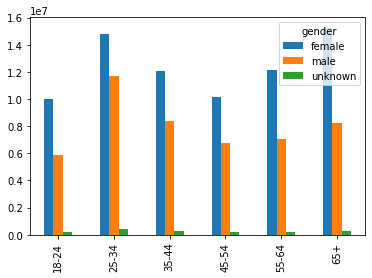

In [21]:
#Overall distribution for all politicians
test.T.plot(kind='bar', style='Spring')


In [22]:
test_2 = test.T.drop(columns='unknown')
test_2 = test_2.reset_index()


In [23]:
test_2['male'] = test_2['male'].apply(lambda x: x*(-1))


In [24]:
test_2

gender,index,female,male
0,18-24,9.969416e+06,-5.875263e+06
1,25-34,1.476539e+07,-1.168603e+07
2,35-44,1.204703e+07,-8.362113e+06
3,45-54,1.017166e+07,-6.763811e+06
4,55-64,1.213529e+07,-7.064451e+06
5,65+,1.524924e+07,-8.230505e+06


[Text(0.5, 0, 'Population (hundreds of millions)'),
 Text(0, 0.5, 'Age-Group'),
 Text(0.5, 1.0, 'Total population distribution')]

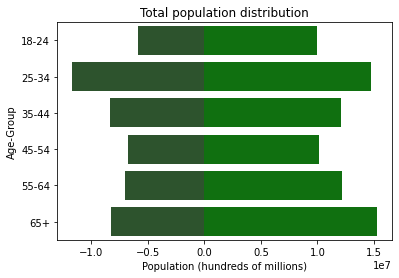

In [25]:
import seaborn as sns

sns.color_palette("Blues", as_cmap=True)


age_class = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

pyramid = sns.barplot(x='male', y='index', data=test_2, order=age_class, color="green", saturation=0.3)
pyramid = sns.barplot(x='female', y='index', data=test_2, order=age_class, color="green", saturation=0.75)

pyramid.set(xlabel="Population (hundreds of millions)", ylabel="Age-Group", title = "Total population distribution")


In [26]:
test

,18-24,25-34,35-44,45-54,55-64,65+
gender,,,,,,
female,9.969416e+06,1.476539e+07,1.204703e+07,1.017166e+07,1.213529e+07,1.524924e+07
male,5.875263e+06,1.168603e+07,8.362113e+06,6.763811e+06,7.064451e+06,8.230505e+06
unknown,2.381870e+05,3.929163e+05,3.048581e+05,2.101015e+05,2.237900e+05,3.113589e+05


# Democrats vs. Republicans

In [27]:
congress = pd.read_csv('/home/gustavgyrst/Desktop/research_project/political-ad-api/src/data_sets/legislators_fb_info_final.csv')


In [28]:
congress

,Unnamed: 0,Unnamed: 0.1,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id
0,0,0,Sherrod,Brown,Sherrod Brown,sen,OH,NaN,Democrat,SenatorSherrodBrown,NaN,0,6266829799
1,1,1,Maria,Cantwell,Maria Cantwell,sen,WA,NaN,Democrat,senatorcantwell,Senator Maria Cantwell,100044609161538,9351652533
2,2,2,Benjamin,Cardin,Benjamin L. Cardin,sen,MD,NaN,Democrat,senatorbencardin,Senator Ben Cardin,100044326544838,no match
3,3,3,Thomas,Carper,Thomas R. Carper,sen,DE,NaN,Democrat,tomcarper,Senator Tom Carper,100044593172202,165571920202215
4,4,4,Robert,Casey,"Robert P. Casey, Jr.",sen,PA,NaN,Democrat,SenatorBobCasey,U.S. Senator Bob Casey,100044143479624,6781166087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,533,Claudia,Tenney,Claudia Tenney,rep,NY,22.0,Republican,NaN,NaN,0,183020072173458
534,534,534,Julia,Letlow,Julia Letlow,rep,LA,5.0,Republican,NaN,NaN,0,101501768597429
535,535,535,Troy,Carter,Troy A. Carter,rep,LA,2.0,Democrat,NaN,NaN,0,876319055750124
536,536,536,Melanie,Stansbury,Melanie A. Stansbury,rep,NM,1.0,Democrat,NaN,NaN,0,128551641258085


In [29]:
party = 'Republican'

party_members = congress[congress["party"] == party]  # get all page id's that match the given party

#Male
demographics_democrats_male = demographics_male[demographics_male.page_id.isin(party_members.page_id)] # get all the ads where page id matches with the party page id's

#Female
demographics_democrats_female = demographics_female[demographics_female.page_id.isin(party_members.page_id)] # get all the ads where page id matches with the party page id's

#Unknown
demographics_democrats_unknown = demographics_unknown[demographics_unknown.page_id.isin(party_members.page_id)]


In [30]:
demographics_democrats_male_g = demographics_democrats_male.groupby('page_id').sum()
demographics_democrats_female_g = demographics_democrats_female.groupby('page_id').sum()
demographics_democrats_unknown_g = demographics_democrats_unknown.groupby('page_id').sum()

demographics_democrats_male_g['gender'] = 'male'
demographics_democrats_female_g['gender'] = 'female'
demographics_democrats_unknown_g['gender'] = 'unknown'


In [31]:
#concatenating the frames
frames_democrats = [demographics_democrats_female_g,demographics_democrats_male_g,demographics_democrats_unknown_g]
total_democrats = pd.concat(frames_democrats)


In [32]:
democrats = total_democrats.groupby('gender').sum()


In [33]:
democrats

,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
gender,,,,,,,,,
female,1286935,0.0,18173.380571,108245.273021,147312.167424,117743.190428,140124.703236,217771.088098,0.0
male,1286935,0.0,29717.857937,55796.279061,50546.114583,77463.555560,139377.755077,179935.128706,0.0
unknown,1286935,0.0,152.526977,403.176853,603.341067,729.292416,1106.548973,1733.903014,0.0


In [34]:
democrats.reset_index(inplace=True)



In [35]:
democrats

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,1286935,0.0,18173.380571,108245.273021,147312.167424,117743.190428,140124.703236,217771.088098,0.0
1,male,1286935,0.0,29717.857937,55796.279061,50546.114583,77463.555560,139377.755077,179935.128706,0.0
2,unknown,1286935,0.0,152.526977,403.176853,603.341067,729.292416,1106.548973,1733.903014,0.0


In [36]:
democrats2 = democrats.drop(democrats.index[2])

In [37]:
democrats2

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,1286935,0.0,18173.380571,108245.273021,147312.167424,117743.190428,140124.703236,217771.088098,0.0
1,male,1286935,0.0,29717.857937,55796.279061,50546.114583,77463.555560,139377.755077,179935.128706,0.0


In [38]:
democrats.set_index('gender', inplace=True)


In [39]:
democrats.drop(columns=['impressions_hi', '13-17', 'unknown'], inplace=True)
democrats2.drop(columns=['impressions_hi', '13-17', 'unknown'], inplace=True)

In [40]:
democrats2 = democrats2.set_index('gender')


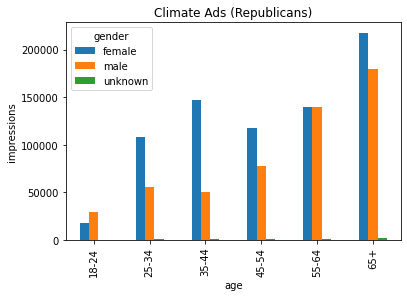

In [41]:
title = "Climate Ads" + " (" + party + "s)"
plot = democrats.T.plot(kind='bar', style='blues' , title=title, ylabel='impressions', xlabel='age')

fig = plot.get_figure()
fig.savefig("Republicans_with_unknown_demographic_dist_climate_ads.pdf")


In [42]:
democrats2.T

gender,female,male
18-24,18173.380571,29717.857937
25-34,108245.273021,55796.279061
35-44,147312.167424,50546.114583
45-54,117743.190428,77463.555560
55-64,140124.703236,139377.755077
65+,217771.088098,179935.128706


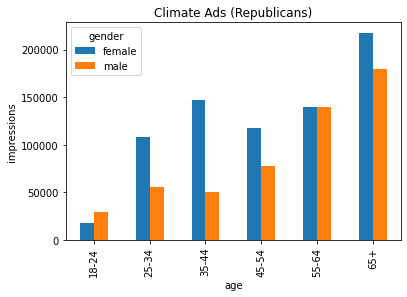

In [43]:

plot_without_unknowns = democrats2.T.plot(kind='bar', style='spring', title=title, ylabel='impressions', xlabel='age')
fig = plot.get_figure()
fig.savefig("Republicans_demographic_dist_climate_ads.pdf")


In [44]:
democrats2_modified = democrats2.T.reset_index()


In [45]:
democrats2_modified
democrats2_modified['male'] = democrats2_modified['male'].apply(lambda x: x*(-1))

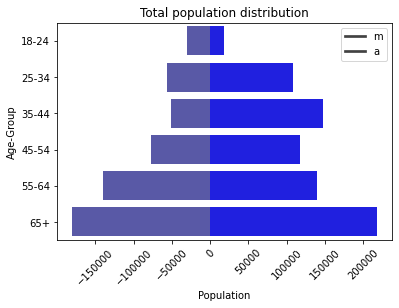

In [57]:
age_class = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

pyramid_byparty = sns.barplot(x='male', y='index', data=democrats2_modified, order=age_class, color="blue", saturation=0.3)
pyramid_byparty = sns.barplot(x='female', y='index', data=democrats2_modified, order=age_class, color="blue", saturation=0.75)

pyramid_byparty.set(xlabel="Population", ylabel="Age-Group", title = "Total population distribution")

plt.xticks(rotation=45)
plt.legend("male")


# Older Code:

# Gender Distribution (Alone)

In [47]:
#Random sum check
sum = 0
for i in df.demographic_distribution[0]:
    sum += float(i.get('percentage'))
print("The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100", sum)
#So... they don't even sum up to a hundred



The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100 1.0000010000000001


In [48]:
list_of_failed_g = []
count_unknown =0
def get_gender_distribution(row):
    
    #initializing percentages
    percentage_male = 0.0
    percentage_female = 0.0
    percentage_unknown = 0.0

    try:
        for item in row.demographic_distribution:
            if item['gender'] == 'male':
                percentage_male += float(item['percentage'])
            elif item['gender'] == 'female':
                percentage_female += float(item['percentage'])
            elif item['gender'] == 'unknown':
                percentage_unknown += float(item['percentage'])
                count_unknown+=1
    except:
        list_of_failed_g.append(lst)
    
    avg_imp = float(row['avg_impressions'])
    lst_all_genders = [percentage_male, percentage_female, percentage_unknown]
    for i in range(3):
        lst_all_genders[i] = lst_all_genders[i]*avg_imp
    
    #Getting the avg impression to get the weight of the gender distribution
    return pd.Series(lst_all_genders)